# Library

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.preprocessing import text, sequence

from keras.models import Model, Sequential
from keras.layers import Flatten, Dense

from keras.layers import Dense, Embedding, Input, SimpleRNN, LSTM, Bidirectional
from keras.layers import Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


# Data

## Train

In [2]:
df_train = pd.read_csv("../data/input/train.csv")
targets = [
    "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"
]

## Test

In [3]:
df_test = pd.read_csv("../data/input/test.csv")
df_test.loc[df_test.comment_text.isnull(), "comment_text"] = ""

# Train, Valid

In [4]:
any_category_positive = np.sum(df_train[targets], 1)

print('Distribution of Total Positive Labels (important for validation)')
print(pd.value_counts(any_category_positive))

X_train, X_val, y_train, y_val = train_test_split(
    df_train.comment_text,
    df_train[targets],
    test_size=0.3,
    stratify=any_category_positive,
    random_state=1607)
print('Training:', X_train.shape)
print('Testing:', X_val.shape)

Distribution of Total Positive Labels (important for validation)
0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64
Training: (111699,)
Testing: (47872,)


# Global parameters

In [5]:
batch_size = 32
epochs = 5
max_features = 20000
maxlen = 100

# Preprocessing : Tokens

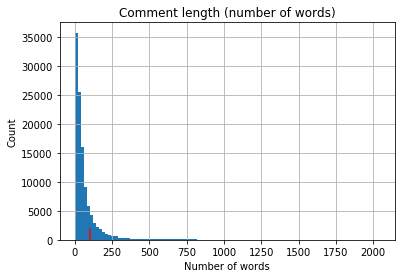

In [6]:
X_train.map(lambda x : len(x.split(" "))).hist(bins=100)
plt.vlines(100, ymin=0, ymax=2000, colors="red")
plt.title("Comment length (number of words)")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.show()

In [7]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_val = tokenizer.texts_to_sequences(X_val)

X_train = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_val = sequence.pad_sequences(list_tokenized_val, maxlen=maxlen)

# Simple neural network

In [8]:
embedding_size = 50

In [9]:
# Define model
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Flatten())
model.add(Dense(6, activation='sigmoid')) # 6 because we want to predict 6 classes

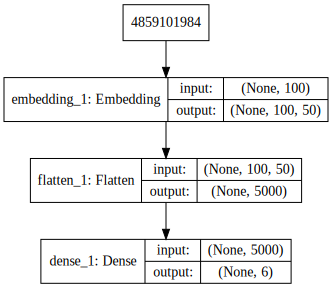

In [10]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Show model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 30006     
Total params: 1,030,006
Trainable params: 1,030,006
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 70s 623us/step - loss: 0.0791 - acc: 0.9752 - val_loss: 0.0708 - val_acc: 0.9784
Epoch 2/5
111699/111699 [==============================] - 88s 788us/step - loss: 0.0540 - acc: 0.9815 - val_loss: 0.0686 - val_acc: 0.9786
Epoch 3/5
111699/111699 [==============================] - 64s 571us/step - loss: 0.0401 - acc: 0.9859 - val_loss: 0.0692 - val_acc: 0.9793
Epoch 4/5
111699/111699 [==============================] - 82s 730us/step - loss: 0.0281 - acc: 0.9903 - val_loss: 0.0776 - val_acc: 0.9794
Epoch 5/5
111699/111699 [==============================] - 80s 713us/step - loss: 0.0200 - acc: 0.9937 - val_loss: 0.0860 - val_acc: 0.9792


In [14]:
model.save_weights('../data/work/simple_neural_network.h5')

In [15]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

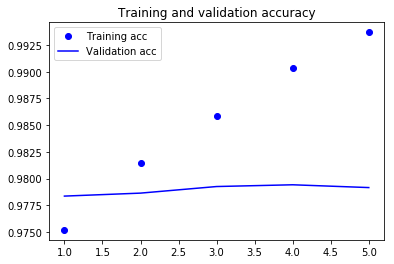

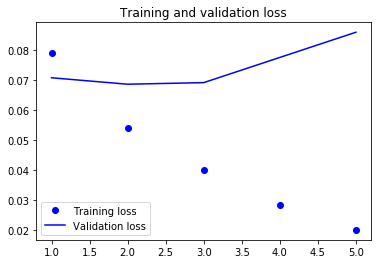

In [16]:
plot_history(history)

# Pre-trained embedding

In [17]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def get_embedding_matrix(tokenizer, path_glove, embed_size,
                         max_features=20000):
    embeddings_index = dict(
        get_coefs(*o.strip().split()) for o in open(path_glove))
    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()

    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words,
                                                            embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [19]:
glove_path = "../data/glove/glove.6B.50d.txt"
embedding_matrix = get_embedding_matrix(
    tokenizer=tokenizer, path_glove=glove_path, embed_size=50, max_features=max_features)

# Simple neural network with pre-trained embedding

In [ ]:
# Define model
model = Sequential()
model.add(
    Embedding(
        max_features,
        embedding_matrix.shape[1],
        input_length=maxlen,
        weights=[embedding_matrix]))
model.add(Flatten())
model.add(Dense(6, activation='sigmoid'))
# 6 because we want to predict 6 classes

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Show model
model.summary()

In [ ]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

In [ ]:
model.save_weights('../data/work/simple_neural_network_pretrained_embedding.h5')

In [ ]:
plot_history(history)

# Simple RNN

In [ ]:
# Define model
model = Sequential()
model.add(Embedding(max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(SimpleRNN(32))
model.add(Dense(6, activation='sigmoid')) # 6 because we want to predict 6 classes

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Show model
model.summary()

In [ ]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

In [ ]:
model.save_weights('../data/work/simple_rnn.h5')

In [ ]:
plot_history(history)

In [ ]:
embedding_matrix.shape

# Stacked RNN

In [ ]:
# Define model
model = Sequential()
model.add(
    Embedding(
        max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(6, activation='sigmoid'))
# 6 because we want to predict 6 classes

In [ ]:
# Show model
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# Compile model
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Show model
model.summary()

In [ ]:
# Fit model
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val))

In [ ]:
model.save_weights('../data/work/stacked_rnn.h5')

In [ ]:
plot_history(history)

# LSTM

In [ ]:
# Define model
model = Sequential()
model.add(Embedding(max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(LSTM(32))
model.add(Dense(6, activation='sigmoid')) # 6 because we want to predict 6 classes

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Show model
model.summary()

In [ ]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

In [ ]:
model.save_weights('../data/work/simple_lstm.h5')

In [ ]:
plot_history(history)

# Stacked LSTM

In [ ]:
# Define model
model = Sequential()
model.add(
    Embedding(
        max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(
    6, activation='sigmoid'))  
# 6 because we want to predict 6 classes

In [ ]:
# Compile model
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Show model
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# Show model
model.summary()

In [ ]:
# Fit model
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val))

In [ ]:
model.save_weights('../data/work/stacked_lstm.h5')

In [ ]:
plot_history(history)

# Bi-LSTM

In [ ]:
# Define model
model = Sequential()
model.add(Embedding(max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(6, activation='sigmoid')) # 6 because we want to predict 6 classes

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Show model
model.summary()

In [ ]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

In [ ]:
model.save_weights('../data/work/bidirectional_lstm.h5')

In [ ]:
plot_history(history)

# Stacked Bi-LSTM

In [ ]:
# Define model
model = Sequential()
model.add(Embedding(max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(6, activation='sigmoid')) 
# 6 because we want to predict 6 classes

In [ ]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Show model
model.summary()

In [ ]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

In [ ]:
model.save_weights('../data/work/stacked_bidirectional_lstm.h5')

In [ ]:
plot_history(history)

# LSTM, Pooling and regularization 

In [ ]:
# Define model
model = Sequential()
model.add(
    Embedding(
        max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(
    Bidirectional(
        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(6, activation='sigmoid'))

In [ ]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Show model
model.summary()

In [ ]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

In [ ]:
model.save_weights('../data/work/complete_lstm.h5')

In [ ]:
plot_history(history)